# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [242]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [243]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

In [244]:
##Intermediary variables
new_data_train = data_train[:,:9] # get rid of last column
new_data_test = data_test[:,:9] 

X_train = new_data_train[:,:8] # Only the features
t_train = new_data_train[:,-1] # Target of training set
N_train = X_train.shape[0]

X_test = new_data_test[:,:8]
t_test = new_data_test[:,-1]
N_test = X_test.shape[0]

moy_train = np.mean(new_data_train,axis=0)
std_train = np.std(new_data_train,axis=0)

data_train_norm = (new_data_train-moy_train)/std_train
data_test_norm = (new_data_test-moy_train)/std_train

X_train_norm = data_train_norm[:,:8]
t_train_norm = data_train_norm[:,-1]

X_test_norm = data_test_norm[:,:8]
t_test_norm = data_test_norm[:,-1]

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

[[ 1.          0.30023199  0.28632427  0.06316772  0.59294913  0.69204308
   0.42641407  0.48316136]
 [ 0.30023199  1.          0.31672347  0.43704154  0.18105448  0.15682859
   0.02355821  0.07416632]
 [ 0.28632427  0.31672347  1.          0.28734645  0.12890226  0.1729514
   0.36591512  0.27580573]
 [ 0.06316772  0.43704154  0.28734645  1.         -0.1391468  -0.08853456
   0.03299215 -0.03040382]
 [ 0.59294913  0.18105448  0.12890226 -0.1391468   1.          0.67124021
   0.30687537  0.48135774]
 [ 0.69204308  0.15682859  0.1729514  -0.08853456  0.67124021  1.
   0.47643684  0.66253335]
 [ 0.42641407  0.02355821  0.36591512  0.03299215  0.30687537  0.47643684
   1.          0.7570565 ]
 [ 0.48316136  0.07416632  0.27580573 -0.03040382  0.48135774  0.66253335
   0.7570565   1.        ]]


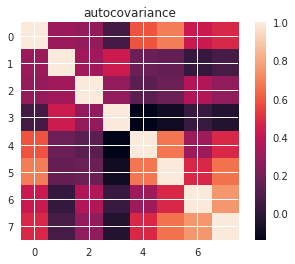

In [245]:
# Preliminary questions
autocovariance_train_norm = np.matmul(X_train_norm.T,X_train_norm)/N_train

print(autocovariance_train_norm)
plt.imshow(autocovariance_train_norm)
plt.title("autocovariance")
plt.colorbar()

In the diagonal, autocovariance_train_norm[i,i] = Var(feature_i) = 1 because data is normalized.
When i!=j, autocovariance_train_norm[i,j] = cov(X_i,X_j)
Some features are very correlated, like feature_0 and feature_5, or feature_6 and feature_7.
That means that we could reduce the dimensionality of our problem, because some features are redundant.

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [246]:
# Exercise 1
#Build the matrix of features X_train for the training set, the first column is made of ones
X_train_norm_ones = np.concatenate((np.ones((N_train,1)),X_train_norm), axis =1)
X_test_norm_ones = np.concatenate((np.ones((N_test,1)),X_test_norm),axis=1)


#Estimate the regression vector beta_hat 
beta_hat = la.multi_dot([la.inv(np.dot(X_train_norm_ones.T,X_train_norm_ones)),X_train_norm_ones.T,t_train])

#Estimate the prediction error (quadratic error) from the test set.
t_test_hat = np.dot(X_test_norm_ones,beta_hat)

mean_pred_error1 = np.mean(np.square(t_test_hat-t_test))
print("Mean prediction error on test set:",mean_pred_error1)

t_train_hat=np.dot(X_train_norm_ones,beta_hat)
print("Mean prediction on training set:",np.mean(np.square(t_train_hat-t_train)))

Mean prediction error on test set: 0.5212740055076004
Mean prediction on training set: 0.43919976805833433


The value of beta_hat[0] corresponds to the intercept term (multiplied by the 1 added to X)

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

In [247]:
# Exercise 2
#Compute Z score
p=8
t_train_hat = np.dot(X_train_norm_ones,beta_hat)

sigma_hat= np.sqrt((1/(N_train-p-1)) * np.sum(np.square(t_train-t_train_hat)))
v=np.diag(la.inv((X_train_norm_ones.T).dot(X_train_norm_ones)))
std_error = sigma_hat*np.sqrt(v)
Z_score = beta_hat/std_error
print("Z_scores: \n",Z_score)


#Set nonsignificant features to 0
mask = np.nonzero(Z_score<=2)
beta_hat_reduced = beta_hat.copy()
beta_hat_reduced[mask]=0
print("Beta_hat:\n", beta_hat)
print("Beta_hat reduced:\n", beta_hat_reduced)


#Compute prediction and error
t_test_hat_reduced = np.dot(X_test_norm_ones,beta_hat_reduced)
mean_pred_reduced_error = np.mean(np.square(t_test_hat_reduced-t_test))
print("Mean prediction error on test set:",mean_pred_reduced_error)

t_train_hat_reduced=(np.dot(X_train_norm_ones,beta_hat_reduced))
print("Mean prediction error on training set:",np.mean(np.square(t_train_hat_reduced-t_train)))

Z_scores: 
 [28.18152744  5.36629046  2.75078939 -1.39590898  2.05584563  2.46925518
 -1.86691264 -0.14668121  1.73783972]
Beta_hat:
 [ 2.45234509  0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025
 -0.28684075 -0.02075686  0.27526843]
Beta_hat reduced:
 [2.45234509 0.71104059 0.29045029 0.         0.21041951 0.30730025
 0.         0.         0.        ]
Mean prediction error on test set: 0.45222661607310993
Mean prediction error on training set: 0.5047993813830515


With the Z score method, the prediction on test set is better than prediction on training set. Indeed, when taking the non relevant features onto account, the beta_hat will overfit the training data.

In [248]:
#Compute new_X_train_norm_ones : X_train_norm_ones without the irrelevant features
new_X_train_norm_ones = np.concatenate((X_train_norm_ones[:,:3],X_train_norm_ones[:,4:6]), axis =1)
new_X_test_norm_ones = np.concatenate((X_test_norm_ones[:,:3],X_test_norm_ones[:,4:6]),axis=1)

print(new_X_train_norm_ones[0])
print(X_train_norm_ones[0])


#Estimate the regression vector beta_hat 
new_beta_hat_reduced = la.multi_dot([la.inv(np.dot(new_X_train_norm_ones.T,new_X_train_norm_ones)),new_X_train_norm_ones.T,t_train])
print(new_beta_hat_reduced.shape) 

#Estimate the prediction error (quadratic error) from the test set.
new_t_test_hat_reduced = np.dot(new_X_test_norm_ones,new_beta_hat_reduced)
new_test_mean_pred_error_reduced = np.mean(np.square(new_t_test_hat_reduced-t_test))
print("Mean prediction error on test set:",new_test_mean_pred_error_reduced)

new_t_train_hat_reduced=np.dot(new_X_train_norm_ones,new_beta_hat_reduced)
new_train_mean_pred_error_reduced = np.mean(np.square(new_t_train_hat_reduced-t_train))
print("Mean prediction error on training set:",new_train_mean_pred_error_reduced)

[ 1.         -1.53517959 -1.81097918 -1.00347165 -0.53708616]
[ 1.         -1.53517959 -1.81097918 -1.98042525 -1.00347165 -0.53708616
 -0.84308399 -1.03949894 -0.90325324]
(5,)
Mean prediction error on test set: 0.45633212204016244
Mean prediction error on training set: 0.4897760410270979


When we compute beta_hat with the new training set (ie removing the irrelevant features), we observe a slightly better prediction for the training set, which makes sense because beta_hat will fit better the training set. However, the difference is not that big, since the initial beta_hat did not have large coefficients for the irrelevant variables. For a bigger training set, we might have a bigger difference.

# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

In [249]:
##Intermediary variables
new_data_train = data_train[:,:9] # get rid of last column
new_data_test = data_test[:,:9] 

X_train = new_data_train[:,:8] # Only the features
t_train = new_data_train[:,-1] # Target of training set
N_train = X_train.shape[0]

X_test = new_data_test[:,:8]
t_test = new_data_test[:,-1]
N_test = X_test.shape[0]

moy_train = np.mean(new_data_train,axis=0)
std_train = np.std(new_data_train,axis=0)

data_train_norm = (new_data_train-moy_train)/std_train
data_test_norm = (new_data_test-moy_train)/std_train

X_train_norm = data_train_norm[:,:8]
t_train_norm = data_train_norm[:,-1]

X_test_norm = data_test_norm[:,:8]
t_test_norm = data_test_norm[:,-1]

X_train_norm_ones = np.concatenate((np.ones((N_train,1)),X_train_norm), axis =1)
X_test_norm_ones = np.concatenate((np.ones((N_test,1)),X_test_norm),axis=1)


In [250]:
# Exercise 3

##Settings
param_lambda = 25
p=8
t_train_mean = np.mean(t_train)

##Compute beta_hat_ridge
beta_hat_ridge = la.multi_dot([la.inv(np.dot(X_train_norm.T,X_train_norm)+param_lambda*np.identity(p)),X_train_norm.T,t_train])
beta_hat_ridge = np.concatenate((t_train_mean,beta_hat_ridge),axis=None)

#Estimate the prediction error
t_test_hat_ridge = np.dot(X_test_norm_ones,beta_hat_ridge)
test_mean_pred_error_ridge = np.mean(np.square(t_test_hat_ridge-t_test))
print("Mean prediction error on test set:",test_mean_pred_error_ridge)

t_train_hat_ridge=np.dot(X_train_norm_ones,beta_hat_ridge)
train_mean_pred_error_ridge = np.mean(np.square(t_train_hat_ridge-t_train))
print("Mean prediction error on training set:",train_mean_pred_error_ridge)

Mean prediction error on test set: 0.49394215991187146
Mean prediction error on training set: 0.5043287699077132


In [251]:
beta_best = [2.477, 0.74, 0.316, 0, 0, 0, 0, 0, 0]
t_test_hat_best = np.dot(X_test_norm_ones,beta_best)
test_mean_pred_error_best = np.mean(np.square(t_test_hat_best-t_test))
print("Mean prediction error on test set:",test_mean_pred_error_best)

t_train_hat_best=np.dot(X_train_norm_ones,beta_best)
train_mean_pred_error_best = np.mean(np.square(t_train_hat_best-t_train))
print("Mean prediction error on training set:",train_mean_pred_error_best)

Mean prediction error on test set: 0.4936867011109828
Mean prediction error on training set: 0.5571614913081956


With regularized least squares, the prediction on test set is better than prediction on training set. As the Z score method, ridge regression avoids overfitting the training data.
The prediction is almost as good as the best beta hat.

# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` rangin from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

Best lambda found (best lambda found for train set): lambda =  0
Best lambda found (best lambda found for validation set): lambda =  6
Best lambda found (best lambda found for test set): lambda =  13
Mean across folds of standard deviation, train set: 0.04115953424063547
Mean across folds of standard deviation, validation set: 0.19446080411798441
Mean across folds of standard deviation, test set: 0.020662981754906613


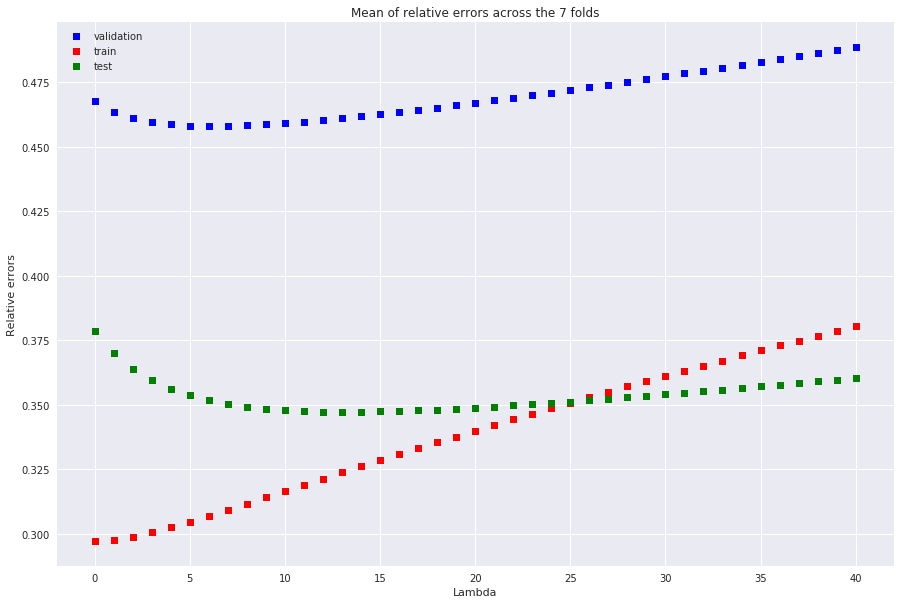

In [252]:
##Settings
lmax = 40
lambda_pos = arange(0,lmax+1) 
N_features = 8

N_val = 10
N_fold = int(np.ceil(N_train/N_val))

##Shuffle training set
np.random.shuffle(new_data_train) 


##Cross-validation
erreur_val = np.zeros((N_fold,lmax+1))
erreur_train = np.zeros((N_fold,lmax+1))
erreur_test = np.zeros((N_fold,lmax+1))
t_test_norm = (t_test - np.mean(t_train, axis=0))/np.std(t_train, axis=0)



for p in range(N_fold):
    # extraction of validation set
    val_set = new_data_train[p*N_val:(p+1)*N_val]
    # extraction of trainset
    train_set = new_data_train[hstack((arange(p*N_val),arange((p+1)*N_val,new_data_train.shape[0])))]
    # normalization of training set
    mean_train = np.mean(train_set,axis=0)
    std_train = np.std(train_set,axis=0)
    
    train_set_norm = (train_set-mean_train)/std_train
    X_train_norm = train_set_norm[:,:8]   
    t_train_norm = train_set_norm[:,-1]
    
    # normalization of validation set
    val_set_norm = (val_set-mean_train)/std_train
    X_val_norm = val_set_norm[:,:8]
    t_val_norm = val_set_norm[:,-1]
    
    # compute error for each lambda for train/val_set and also the test set, which is normalized with the mean of the
    #whole training set
    for param_lambda in range(lmax+1):        
        lambda_id = param_lambda*np.identity(N_features)
        beta_hat_reg = la.multi_dot([la.inv(lambda_id + np.dot(X_train_norm.T,X_train_norm)),X_train_norm.T,t_train_norm])
        
        t_train_hat_norm = X_train_norm.dot(beta_hat_reg)
        erreur_train[p,param_lambda] = np.mean(np.square(t_train_hat_norm-t_train_norm))
        
        t_val_hat_norm = X_val_norm.dot(beta_hat_reg)
        erreur_val[p,param_lambda] = np.mean(np.square(t_val_hat_norm-t_val_norm))
        
        
        t_test_hat_norm = X_test_norm.dot(beta_hat_reg)
        erreur_test[p,param_lambda] = np.mean(np.square(t_test_hat_norm-t_test_norm))

        
std_error_var_train = np.std(erreur_train,axis=0)
std_error_var_val = np.std(erreur_val,axis=0)
std_error_var_test = np.std(erreur_test,axis=0)

##Plots
plt.figure(figsize=(15,10))
plt.title('Mean of relative errors across the 7 folds')
#plt.axis(ymin=0,ymax=1)
plt.xlabel('Lambda')
plt.ylabel('Relative errors')
plt.plot(lambda_pos,np.mean(erreur_val,axis=0),"bs")
plt.plot(lambda_pos,np.mean(erreur_train,axis=0),"rs")
plt.plot(lambda_pos,np.mean(erreur_test,axis=0),"gs")
plt.legend(('validation','train','test'))
best_lambda_val = np.argmin(np.mean(erreur_val,axis=0))
print("Best lambda found (best lambda found for train set): lambda = ",np.argmin(np.mean(erreur_train,axis=0)))
print("Best lambda found (best lambda found for validation set): lambda = ",best_lambda_val)
print("Best lambda found (best lambda found for test set): lambda = ",np.argmin(np.mean(erreur_test,axis=0)))
print("Mean across folds of standard deviation, train set:", np.mean(std_error_var_train))
print("Mean across folds of standard deviation, validation set:",np.mean(std_error_var_val))
print("Mean across folds of standard deviation, test set:",np.mean(std_error_var_test))

- For training data, the best lambda is 0 : indeed, if we only have to predict a target for some x belonging to the training set, we would rather have a model which overfits the training set
- The worst standard deviation is for validation set: it's not surprising because the validation set is very small so changing fold will have a bigger impact
- The error for validation set is much bigger than for the other set. This might again be because the validation set is quite small compared to the test set. In the test set, the error might "average out".

In [256]:
# Prediction with best lambda
##Intermediary variables
new_data_train = data_train[:,:9] # get rid of last column
new_data_test = data_test[:,:9] 

X_train = new_data_train[:,:8] # Only the features
t_train = new_data_train[:,-1] # Target of training set
N_train = X_train.shape[0]

X_test = new_data_test[:,:8]
t_test = new_data_test[:,-1]
N_test = X_test.shape[0]

moy_train = np.mean(new_data_train,axis=0)
std_train = np.std(new_data_train,axis=0)

data_train_norm = (new_data_train-moy_train)/std_train
data_test_norm = (new_data_test-moy_train)/std_train

X_train_norm = data_train_norm[:,:8]
t_train_norm = data_train_norm[:,-1]

X_test_norm = data_test_norm[:,:8]
t_test_norm = data_test_norm[:,-1]

X_train_norm_ones = np.concatenate((np.ones((N_train,1)),X_train_norm), axis =1)
X_test_norm_ones = np.concatenate((np.ones((N_test,1)),X_test_norm),axis=1)


##Settings
param_lambda = 7
p=8
t_train_mean = np.mean(t_train)

##Compute beta_hat_ridge
beta_hat_ridge = la.multi_dot([la.inv(np.dot(X_train_norm.T,X_train_norm)+param_lambda*np.identity(p)),X_train_norm.T,t_train])
beta_hat_ridge = np.concatenate((t_train_mean,beta_hat_ridge),axis=None)
print("Beta_hat with best lambda\n", beta_hat_ridge)

#Estimate the prediction error
t_test_hat_ridge = np.dot(X_test_norm_ones,beta_hat_ridge)
test_mean_pred_error_ridge = np.mean(np.square(t_test_hat_ridge-t_test))
print("Mean prediction error on test set:",test_mean_pred_error_ridge)

t_train_hat_ridge=np.dot(X_train_norm_ones,beta_hat_ridge)
train_mean_pred_error_ridge = np.mean(np.square(t_train_hat_ridge-t_train))
print("Mean prediction error on training set:",train_mean_pred_error_ridge)

Beta_hat with best lambda
 [ 2.45234509  0.57591509  0.28084136 -0.0996297   0.19632083  0.27527834
 -0.12745374  0.01946202  0.18892517]
Mean prediction error on test set: 0.49030863836497207
Mean prediction error on training set: 0.4530029388840299
